In [1]:
# Libraries
import os
import time
import shutil
import pathlib
import itertools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, AveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")



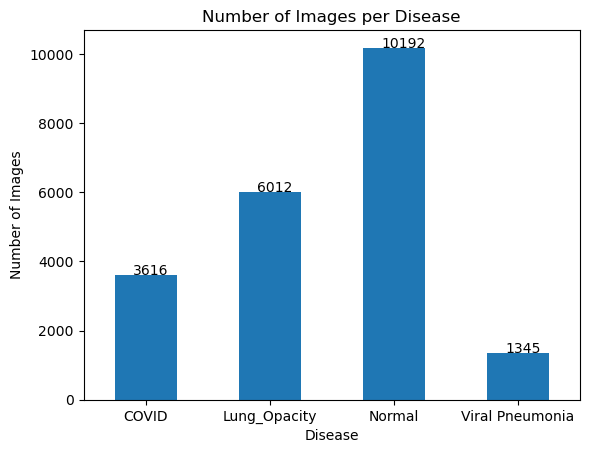

Training data size = 16932, Validation data size = 2116, Testing data size = 2117


In [2]:
# Set the directory containing the image files
data_dir = 'COVID-19_Radiography_Dataset'

# Lists to store filepaths and their labels
filepaths = []
labels = []

# Get all the files present in all 4 folders in the dataset directory and map them to a class name based on what folder it is present
for fold in os.listdir(data_dir):
    foldpath = os.path.join(data_dir, fold)

    if pathlib.Path(foldpath).suffix != '':
        continue
    if os.path.isdir(foldpath):
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            if os.path.isdir(fpath):
                if pathlib.Path(foldpath).suffix == '':
                    # We will not be using Mask Images so ignoring the mask folders
                    if pathlib.Path(fpath).parts[-1] == 'masks' or pathlib.Path(fpath).parts[-1] == 'Masks' or pathlib.Path(fpath).parts[-1] == 'MASKS':
                        continue
                    else:
                        o_file = os.listdir(fpath)
                        for f in o_file:
                            ipath = os.path.join(fpath, f)
                            filepaths.append(ipath)
                            labels.append(fold)
                else:
                    filepaths.append(fpath)
                    labels.append(fold)

# Storing File names and corresponding class in a dataframe
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})


# show the plot to visualize number of images per class
label_counts = df.groupby('labels')['filepaths'].count()
ax = label_counts.plot(kind='bar')

plt.xlabel('Disease')
plt.ylabel('Number of Images')
plt.title('Number of Images per Disease')
plt.xticks(rotation=0)

for i in ax.patches:
    ax.text(i.get_x()+.15, i.get_height()+.5, str(i.get_height()), fontsize=10)
plt.show()

# Split the Data into training, validation, and test sets at a ratio of 80-10-10
strat = df['labels']
train_df, semi_split_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)
strat = semi_split_df['labels']
valid_df, test_df = train_test_split(semi_split_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)


print(f'Training data size = {len(train_df)}, Validation data size = {len(valid_df)}, Testing data size = {len(test_df)}')


In [3]:
# Calculate the length of the test dataset
test_length = len(test_df)

# Find all factors of the test dataset length less than or equal to 80
factors = []
for n in range(1, test_length+1):
    if test_length % n == 0 and test_length/n <= 80:
        factors.append(n)

# the test batch size is the largest of the factors
test_batch_size = max(sorted(factors, reverse=True))

# Calculate the number of steps per epoch for the test dataset
test_steps = test_length // test_batch_size

# Define a function that returns the input image unchanged
def scalar(img):
    return img

# Set up image data generators for the training, validation, and test datasets
aug_train = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
aug_test = ImageDataGenerator(preprocessing_function=scalar)

train_gen = aug_train.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=16
)

valid_gen = aug_test.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=16
)

test_gen = aug_test.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)


Found 16932 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.


In [4]:
train_data = train_gen.class_indices
classes = list(train_data.keys())
images, labels = next(train_gen)
batch_size = len(labels)        # length of batch size

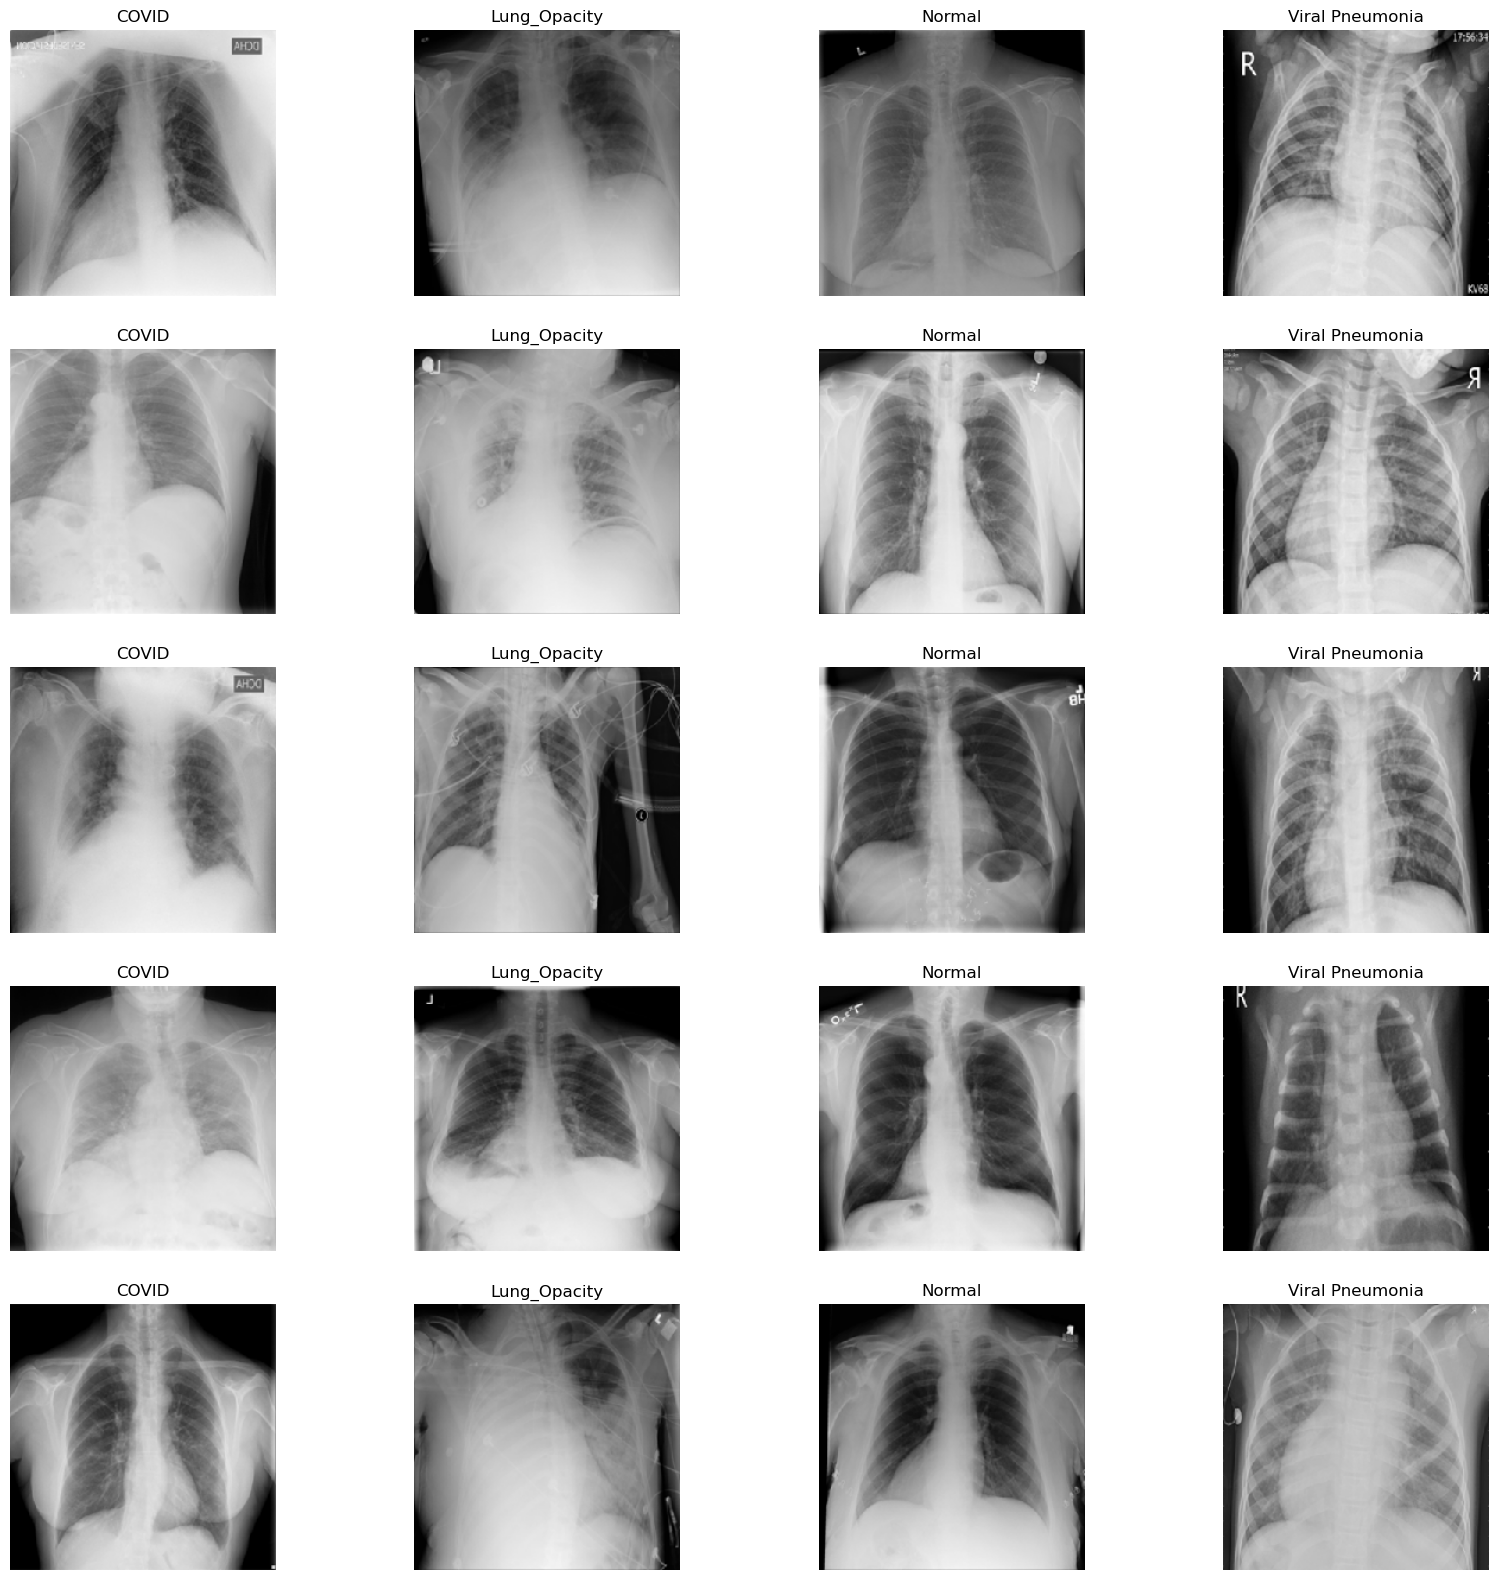

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Get class names and number of classes
class_names = list(train_gen.class_indices.keys())
num_classes = len(class_names)

# Create a dictionary to store images for each class
class_images = {class_name: [] for class_name in class_names}

# Loop over the samples until 5 images per class are found
while True:
    images, labels = next(train_gen)
    for j in range(len(labels)):
        class_name = class_names[np.argmax(labels[j])]
        if len(class_images[class_name]) < 5:
            class_images[class_name].append(images[j])

    # Stop once 5 images per class are found
    if all(len(images) == 5 for images in class_images.values()):
        break

# Create a figure with 5 rows and N columns
fig, axs = plt.subplots(5, num_classes, figsize=(20, 20))

# Loop over the classes and plot the corresponding images
for i in range(num_classes):
    for j in range(5):
        axs[j, i].imshow(class_images[class_names[i]][j]/255)
        axs[j, i].set_title(class_names[i])
        axs[j, i].axis('off')

plt.show()


In [6]:
# Set the batch size, image size, and number of classes
batch_size = 16
img_height, img_width = 224, 224
num_classes = len(train_gen.class_indices)


# Define the LeNet model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
#model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


Metal device set to: Apple M1 Pro


2023-04-19 17:53:18.471214: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-19 17:53:18.471352: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 average_pooling2d (AverageP  (None, 111, 111, 32)     0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 54, 54, 64)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [9]:
# Train the model
history = model.fit(
    train_gen,
    epochs=20,
    callbacks = early_stop,
    validation_data=valid_gen,)

Epoch 1/20


2023-04-19 17:53:18.766444: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-19 17:53:18.964805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1058/1059 [============================>.] - ETA: 0s - loss: 19.4720 - accuracy: 0.6195

2023-04-19 17:54:07.159020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1059/1059 [==============================] - 53s 49ms/step - loss: 19.4544 - accuracy: 0.6197 - val_loss: 0.8288 - val_accuracy: 0.6526
Epoch 2/20
1059/1059 [==============================] - 52s 49ms/step - loss: 0.6970 - accuracy: 0.7177 - val_loss: 0.7420 - val_accuracy: 0.7009
Epoch 3/20
1059/1059 [==============================] - 52s 49ms/step - loss: 0.5812 - accuracy: 0.7691 - val_loss: 0.6901 - val_accuracy: 0.7339
Epoch 4/20
1059/1059 [==============================] - 52s 49ms/step - loss: 0.4836 - accuracy: 0.8127 - val_loss: 0.6853 - val_accuracy: 0.7647
Epoch 5/20
1059/1059 [==============================] - 52s 49ms/step - loss: 0.4124 - accuracy: 0.8437 - val_loss: 0.7429 - val_accuracy: 0.7585
Epoch 6/20
1059/1059 [==============================] - 52s 49ms/step - loss: 0.3482 - accuracy: 0.8679 - val_loss: 0.7163 - val_accuracy: 0.7585
Epoch 7/20
1059/1059 [==============================] - 52s 49ms/step - loss: 0.3194 - accuracy: 0.8830 - val_loss: 0.8443 - val_accur

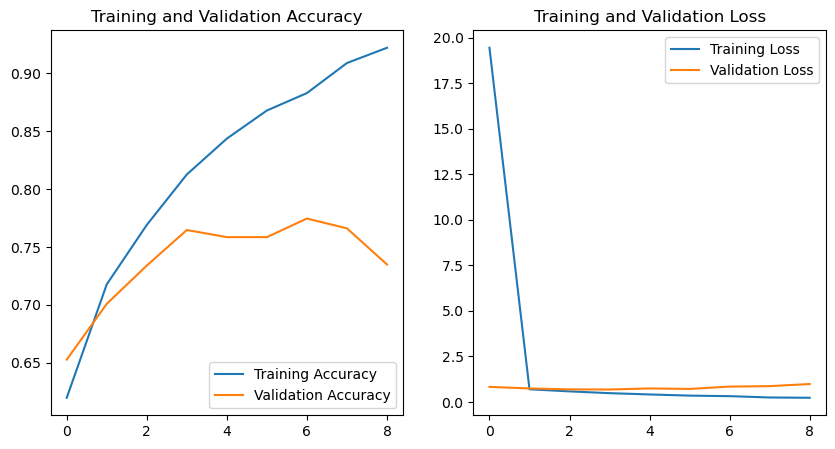

In [13]:
# Plot the training and validation accuracy over epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc)) #Change with the number of epochs

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot the training and validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [14]:
model.save('LeNet_Saved.h5')

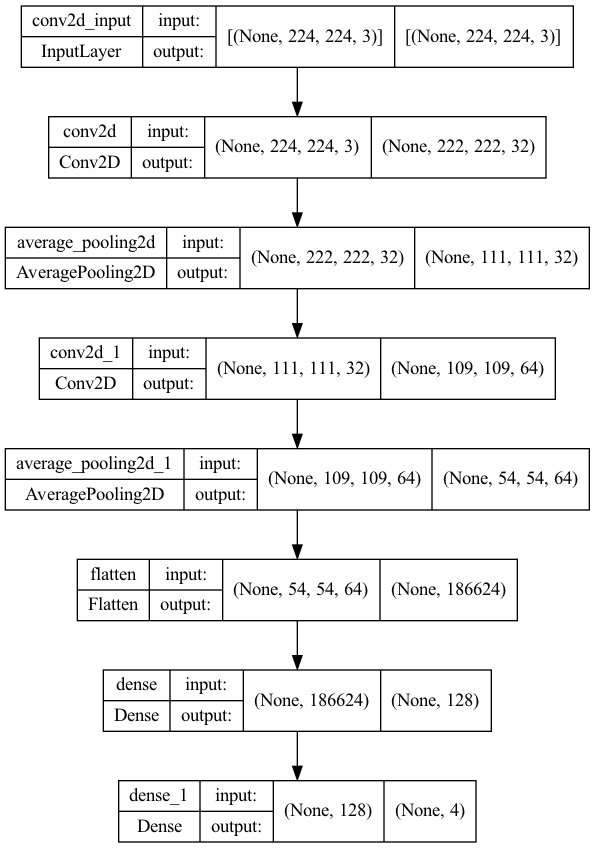

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
